In [220]:
%reload_ext autoreload
%autoreload 2

In [221]:
# imports
import os
import ast
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt


from scipy import stats
from datetime import datetime as dt

In [222]:
import helpers


movies, characters = helpers.import_movies_data("./data/")


/Users/chuck/IdeaProjects/ada-2023-project-zalix/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


In [223]:
movies.head(3)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0


# Diversity
As major film studios across the globe face increasing criticism from regular movie-goers and critics alike for the lack of diversity on and off screen, we want to explore how diversity has influenced the masses' impression of a film from the perspective of ethnicity and sex. As these calls for greater diversity often demands greater representation for the underrepresented racial and ethnic groups on the big screen, we evaluate a film's "ethnic diversity" by the number of different ethnicities among its cast members. As Figure X show, the number of cast ethnicities in a film follows a power law distribution, where only 21.3% of films has a cast of at least 3 ethnicities. // TODO: for sex, justify % of female cast members

## Ethnicity
This section explores: 
- Is the global ethnic demograhics of movie actors shaking up to be more diverse with time? Is this shift reflected on the silver screen with more ethnically diverse films? 
- Is greater ethnic representation appreciated/rewarded by reviewers with higer ratings?
- Does ethnic diversity in cast contribute to more positive movie ratings? 

In [224]:
#### this section explores the relationship between the ethnic make-up of a movie's cast and its ratings 

### research question 1: how has the ethnic demographics changed over the years in the global acting workforce? 

(375,)


<Axes: >

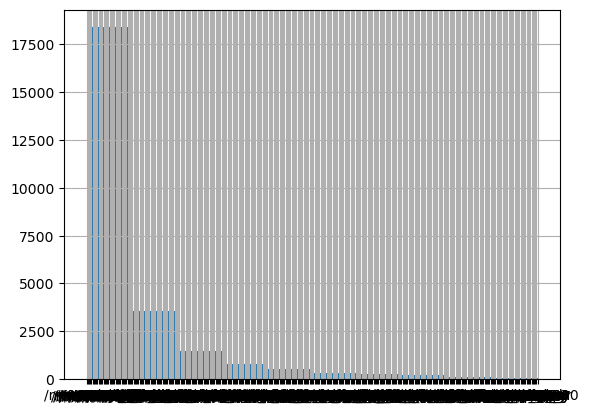

In [225]:
## data preprocessing
# NOTE: INNER join movies with characters (drop if either side's info is missing)
movies_ratings_characters = pd.merge(movies, characters, how='inner', on=['wikipedia_movie_ID'])
movies_ratings_characters.head(3)

## exploratory data analysis
# show distribution of ethnicities (across all movies and across all years)
ethnicity_count = movies_ratings_characters['actor_ethnicity'].value_counts()
print(ethnicity_count.shape)
# NOTE: half ethnicities have frequency < 10
# print(ethnicity_count.values)

movies_ratings_characters['actor_ethnicity'].hist()

In [226]:
## compute the number of actor ethnicities in each decade
# add decade column
movies_ratings_characters['decade'] = movies_ratings_characters['year_released'].apply(lambda x: int(x/10)*10)
# compute the number of actor ethnicities for each decade based on actors who have at least one film released in that decade
# NOTE: ignore missing values in ethnicity column
decade_ethnicity = pd.crosstab(movies_ratings_characters['decade'], movies_ratings_characters['actor_ethnicity'])
decade_num_ethnicities = decade_ethnicity.apply(lambda x: (x != 0).sum(), axis=1)

# NOTE: last decade's drop explained by data collected till 2013 
display(decade_num_ethnicities)

decade
1900      1
1910     12
1920     27
1930     39
1940     55
1950     72
1960     80
1970    126
1980    174
1990    239
2000    312
2010    227
dtype: int64

<Axes: xlabel='decade'>

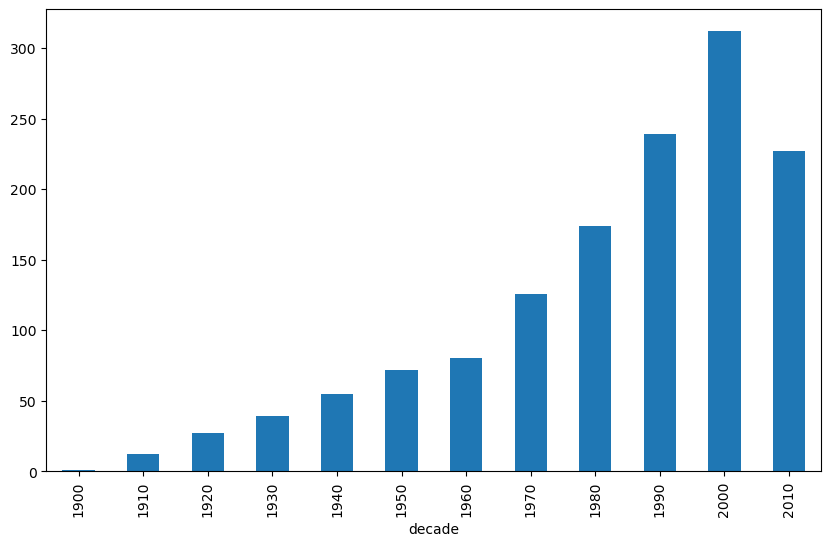

In [227]:
# plot bar chart the number of actor ethnicities in each decade
decade_num_ethnicities.plot.bar(stacked=True, figsize=(10, 6))

Figure X shows that over the century, the acting workforce of the film industry has become increasingly ethnically diverse. There is a consistent rise in the number of ethnicities among actors who have at least one film released that decade. The only drop going into the 2010s is likely because the dataset only includes films released up to 2013.

(12574, 26)
count    12574.000000
mean         6.152505
std          1.032984
min          1.300000
25%          5.600000
50%          6.300000
75%          6.800000
max          9.900000
Name: averageRating, dtype: float64
(2644, 26) 0.2102751709877525


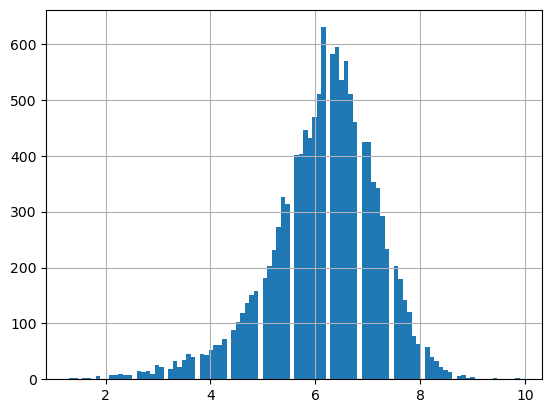

In [228]:
## exploratory data analysis 
# filter dataset to unique movies
# NOTE: number of movies (with ratings) shrank from 14369 to 12574 after joining with characters
df_unique_movies = movies_ratings_characters.drop_duplicates(subset=['wikipedia_movie_ID']).reset_index().set_index('wikipedia_movie_ID')
print(df_unique_movies.shape)

# show distribution of movie ratings
print(df_unique_movies['averageRating'].describe())
# NOTE: roughly normally distributed
df_unique_movies['averageRating'].hist(bins=100)

high_ratings_movies = df_unique_movies[df_unique_movies['averageRating'] >= 7.0]
# NOTE: 21.03% are high-rating films
print(high_ratings_movies.shape, high_ratings_movies.shape[0]/df_unique_movies.shape[0])

# NOTE: hereafter define good films as films with IMDB rating >= 7.0

count    12574.000000
mean         1.964291
std          1.638365
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: actor_ethnicity, dtype: float64
(3020,) 0.24017814537935422


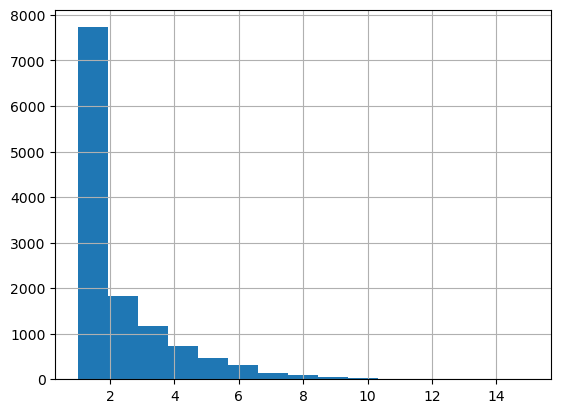

In [229]:
# calculate number of ethnicities per film
# NOTE: missing values in ethnicity column are ignored
num_ethnicities_by_movie = movies_ratings_characters.groupby('wikipedia_movie_ID')['actor_ethnicity'].nunique()
# NOTE fill with 1 if no actor ethnicity info is available for a movie
num_ethnicities_by_movie[num_ethnicities_by_movie == 0] = 1

# show distribution of number of ethnicities per film (across all years)
# NOTE: power law
print(num_ethnicities_by_movie.describe())
num_ethnicities_by_movie.hist(bins=num_ethnicities_by_movie.max())

diverse_movies = num_ethnicities_by_movie[num_ethnicities_by_movie >= 3]
# NOTE: 24.02% films have cast whose number of ethnicities >= 3
print(diverse_movies.shape, len(diverse_movies) / len(num_ethnicities_by_movie))

# NOTE: hereafter, define ethnically diverse films as number of different ethnicities in cast members >= 3

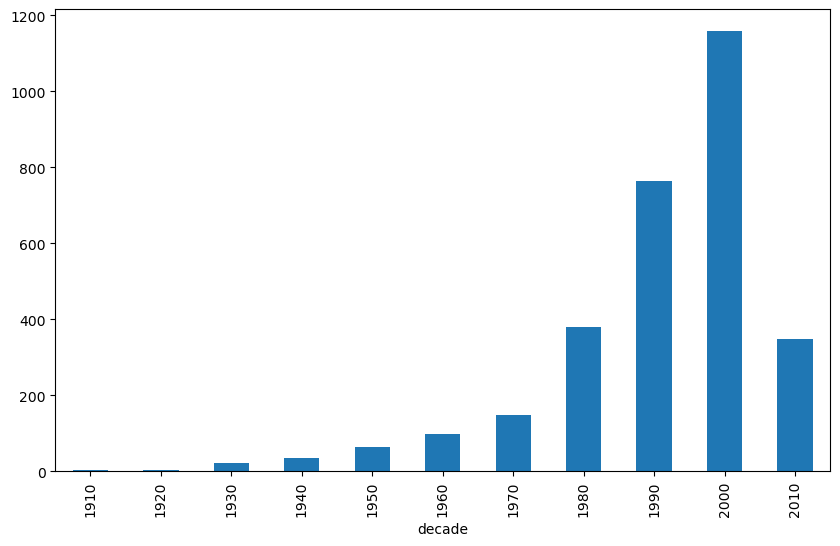

In [230]:
# add number of ethnicities for a movie as a new column
df_unique_movies = df_unique_movies.assign(num_ethnicities=num_ethnicities_by_movie)

# plot the number of ethnically diverse films in each decade
diverse_movies = df_unique_movies[df_unique_movies['num_ethnicities'] >= 3]
ethnic_diverse_movies_count = diverse_movies.groupby('decade').size().plot.bar(stacked=True, figsize=(10, 6))

<ErrorbarContainer object of 3 artists>

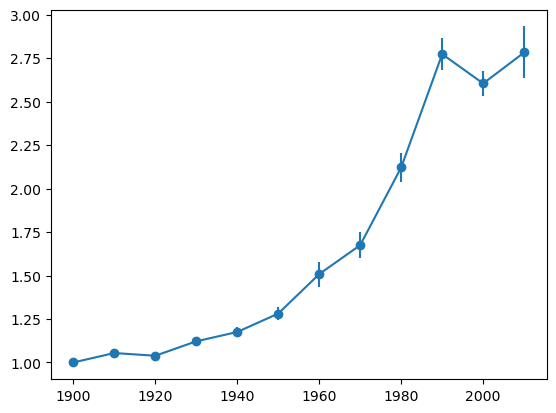

In [231]:
# plot the mean number of cast ethnicities per film in each decade with error bars for 95% confidence interval
mean = df_unique_movies.groupby('decade')['num_ethnicities'].mean()
sem = df_unique_movies.groupby('decade')['num_ethnicities'].sem()

plt.errorbar(mean.index, mean, yerr=1.96*sem, fmt='-o')

The increasingly ethnically diverse workforce is reflected on the silver screen. There is a largely upward trend in the average number of ethnicities among film casts, with the 2000s being the only exception. As film casts move away from consisting solely of one ethnic group, there is also increasingly larger variability in the number of ethnic groups present in a movie. 

In [232]:
# answers research question 1: in the global movie industry, actors are coming from increasingly more diverse ethnic backgrounds over the years

In [233]:
## research question 2: cast ethnic diversity appreciated by audience? (ethnically diverse films outperforms other movies in rating?)

Since the number of ethnicities among cast members has increased to an average of 2.75, we select 3 as the threshold for an "ethnically diverse" cast.

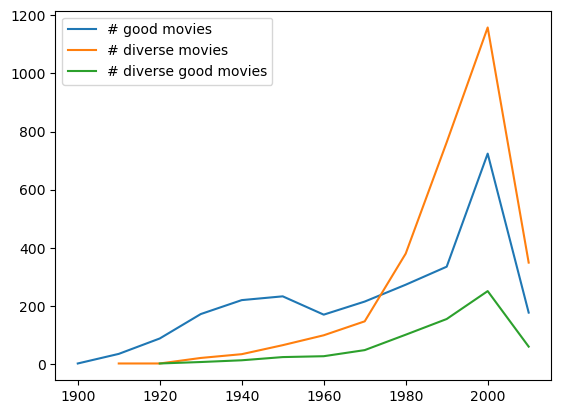

In [234]:
# TODO: need to justify arbitrary threshold of 7.0 for good films and 3 for ethnically diverse films
good_movies = df_unique_movies['averageRating'] >= 7
diverse_movies = df_unique_movies['num_ethnicities'] >= 3
# plot the number of 1) good films 2) ethnically diverse films 3) ethinically diverse & good films in each decade
good_movies_count = df_unique_movies[good_movies].groupby('decade').size()
plt.plot(good_movies_count.index, good_movies_count, label='# good movies')

diverse_movies_count = df_unique_movies[diverse_movies].groupby('decade').size()
plt.plot(diverse_movies_count.index, diverse_movies_count, label='# diverse movies')

diverse_good_movies_count = df_unique_movies[good_movies & diverse_movies].groupby('decade').size()
plt.plot(diverse_good_movies_count.index, diverse_good_movies_count, label='# diverse good movies')
plt.legend()

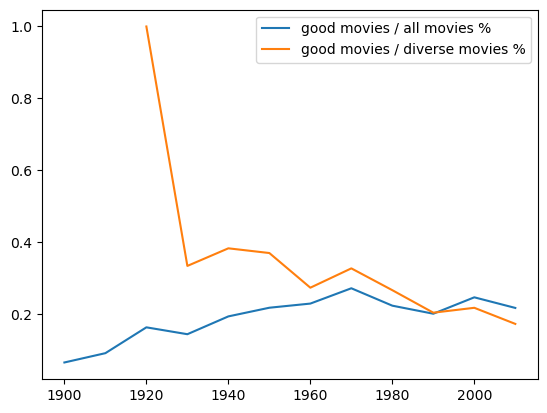

In [235]:
# plot the percentages of highly rated films out of all films vs films with ethnically diverse cast in each decade
good_movies_pct = good_movies_count / df_unique_movies.groupby('decade').size()

diverse_good_movies_pct = diverse_good_movies_count / diverse_movies_count

plt.plot(good_movies_pct.index, good_movies_pct, label='good movies / all movies %')
plt.plot(diverse_good_movies_pct.index, diverse_good_movies_pct, label='good movies / diverse movies %')
plt.legend()

NOTE: chart results differ from expectation (exclude)

<Axes: xlabel='decade'>

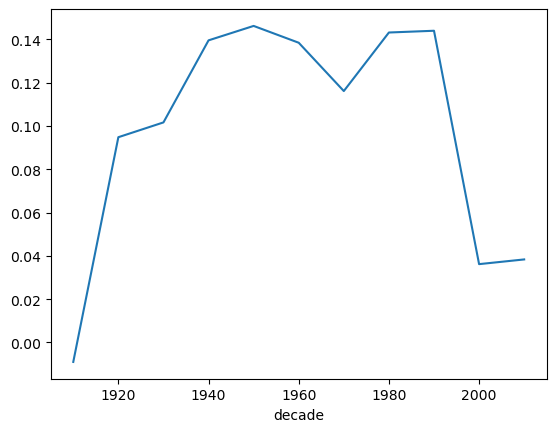

In [236]:
# TODO calculate pearson correlation coefficient between ethnic diversity and movie ratings for each decade
correlations = df_unique_movies.groupby('decade').apply(lambda x: x['num_ethnicities'].corr(x['averageRating'], method='pearson'))

correlations.plot.line()


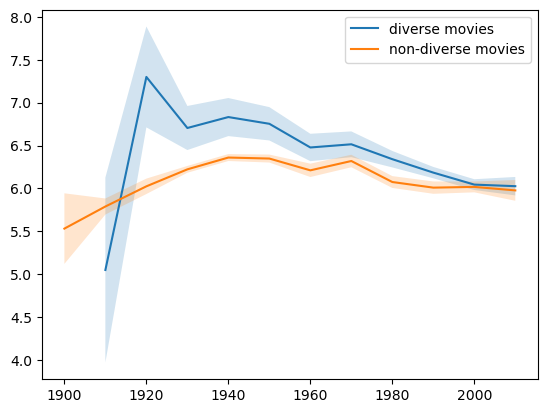

In [237]:
# plot the average ratings of ethnically diverse films vs other films in each decade with error bars for 95% confidence interval
diverse_means = df_unique_movies[diverse_movies].groupby('decade')['averageRating'].mean()
diverse_sme = df_unique_movies[diverse_movies].groupby('decade')['averageRating'].sem()

non_diverse_means = df_unique_movies[~diverse_movies].groupby('decade')['averageRating'].mean()
non_diverse_sme = df_unique_movies[~diverse_movies].groupby('decade')['averageRating'].sem()

plt.plot(diverse_means.index, diverse_means, label='diverse movies')
plt.fill_between(diverse_means.index, diverse_means - 1.96*diverse_sme, diverse_means + 1.96*diverse_sme, alpha=0.2)

plt.plot(non_diverse_means.index, non_diverse_means, label='non-diverse movies')
plt.fill_between(non_diverse_means.index, non_diverse_means - 1.96*non_diverse_sme, non_diverse_means + 1.96*non_diverse_sme, alpha=0.2)

plt.legend()

Since 1920s, films with at least 3 ethnicities among cast members have consistently been rated on average higher than films with a less diverse cast. The non-overlapping 95% Confidence Intervals (CI) before 2000s lends greater confidence that the difference in average ratings is not due to chance. However, while less ethnically diverse films largely maintain a stable average rating between 5.5 to 6.4, there is a overall downward trend with a slimming CI for ethnically diverse films bringing their average rating eventually similar to that of less ethnically diverse films in 2000s. This is reflected also in the Pearson Correlation Coefficients, which stayed positive and above 0.1 since 1930s until a sharp turn down to 0.03 in 2000s.

In [238]:
### research question 3: does having a more ethnically diverse cast contribute to greater acclaim/higher rating? ("appreciation of representation")

In [239]:
# causal analysis/inference: ethnically diverse cast -> higher rating 

# feature selection 
'''
pair match on confounders:
- movie_release_date: encode by splitting into year, month, day columns (no nan)
- movie_languages: extract dict values & one-hot encode
- movie_countries: extract dict values & one-hot encode
- movie_genres: extract dict values & one-hot encode
'''

'\npair match on confounders:\n- movie_release_date: encode by splitting into year, month, day columns (no nan)\n- movie_languages: extract dict values & one-hot encode\n- movie_countries: extract dict values & one-hot encode\n- movie_genres: extract dict values & one-hot encode\n'

In [240]:
# feature encoding
# check percentage of rows with nan in feature columns
df_reg = df_unique_movies[['movie_release_date', 'movie_languages', 'movie_countries', 'movie_genres', 'num_ethnicities', 'decade']].copy()

df_reg = df_reg.replace('{}', np.nan)

print(df_reg.shape)
print(df_reg.isna().sum() / df_reg.shape[0])

# drop rows with nan in any selected feature columns
# NOTE: about 10% of rows dropped
df_reg = df_reg.dropna()
print(df_reg.shape)

(12574, 6)
movie_release_date    0.000000
movie_languages       0.065373
movie_countries       0.032686
movie_genres          0.005567
num_ethnicities       0.000000
decade                0.000000
dtype: float64
(11557, 6)


In [241]:
# split movie_release_date into year, month, day columns
df_reg['movie_release_date_dt'] = pd.to_datetime(df_reg['movie_release_date'])

df_reg['movie_year'] = df_reg['movie_release_date_dt'].dt.year
df_reg['movie_month'] = df_reg['movie_release_date_dt'].dt.month
df_reg['movie_day'] = df_reg['movie_release_date_dt'].dt.day

In [242]:
# extract dict values & one-hot encode movie_languages
# convert cells from string of dict to list of values
df_reg['movie_languages_ls'] = df_reg['movie_languages'].apply(lambda x: list(ast.literal_eval(x).values()))

# one-hot encode the list of values
movie_languages_encoded = df_reg['movie_languages_ls'].str.join('|').str.get_dummies()

# extract dict values & one-hot encode movie_countries
# convert cells from string of dict to list of values
df_reg['movie_countries_ls'] = df_reg['movie_countries'].apply(lambda x: list(ast.literal_eval(x).values()))

# one-hot encode the list of values
movie_countries_encoded = df_reg['movie_countries_ls'].str.join('|').str.get_dummies()

# extract dict values & one-hot encode movie_genres
# convert cells from string of dict to list of values
df_reg['movie_genres_ls'] = df_reg['movie_genres'].apply(lambda x: list(ast.literal_eval(x).values()))

# one-hot encode the list of values
movie_genres_encoded = df_reg['movie_genres_ls'].str.join('|').str.get_dummies()

In [243]:
# feature standardization
# normalize numerical features: movie_year, movie_month, movie_day, movie_runtime
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(df_reg[['movie_year', 'movie_month', 'movie_day']])

In [244]:
# regression
# build logistic regression model to predict a film's probability of being ethnically diverse (as propensity score)
from sklearn.linear_model import LogisticRegression

X = np.concatenate((scaled_features, movie_languages_encoded, movie_countries_encoded, movie_genres_encoded), axis=1)

Y = df_reg['num_ethnicities'] >= 3

propensity = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000).fit(X, Y).predict_proba(X)[:, 1]

In [245]:
# propensity matching
# build graph to exact match on decade and overall match on propensity score
df_reg['propensity'] = propensity

treated = df_reg[df_reg['num_ethnicities'] >= 3]
control = df_reg[df_reg['num_ethnicities'] < 3]

G = nx.Graph()
for ti, t in treated.iterrows():
  for ci, c in control.iterrows():
    # exact match on decade
    if t['decade'] == c['decade']:
      similarity = 1 - np.abs(t["propensity"] - c["propensity"])
      G.add_weighted_edges_from([(ti, ci, similarity)])

# find optimal matching of similar control and treatment pairs 
# NOTE: maxcardinality=False to find closest matches
matching = nx.max_weight_matching(G)

KeyboardInterrupt: 

In [ ]:
# separate treatment and control group subjects  
match_index = np.array(matching.map(lambda x: list(x))).unravel()
match_treated = treated[treated.index.isin(match_index)]
match_control = control[control.index.isin(match_index)]

# compare aggregated outcomes between two groups 
# NOTE: might see simpson's paradox
print(match_treated['averageRating'].describe())
print(match_control['averageRating'].describe())

In [ ]:
# hypothesis testing 
# perform t-test on average ratings of ethnically diverse vs non-ethnically diverse films for each decade 
# null hypothesis: average rating of ethnically diverse films <= average rating of non-ethnically diverse films
# alternative hypothesis: average rating of ethnically diverse films > average rating of non-ethnically diverse films
p_values = df_reg[match_index].groupby('decade').apply(lambda x: stats.ttest_ind(x[x['num_ethnicities' >= 3]], x[x['num_ethnicities' < 3]], alternative='greater')[-1])